In [1]:
sc

In [2]:
import csv
import time
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
from matplotlib import dates
import dateutil.parser
import seaborn as sns
from operator import itemgetter
from pyspark.mllib.fpm import FPGrowth,PrefixSpan,PrefixSpanModel
from functools import reduce
from itertools import groupby
import math

In [5]:
mcc = "/Users/indrikwijaya/Documents/DataSpark_Internship/4th_Project_Staypoint/mcc_list.txt"
grid_submtz = "/Users/indrikwijaya/Documents/grid_sub-mtz.csv"


mcc = sc.textFile(mcc).map(lambda x: x.strip().replace("|",",").split(",")) \
        .map(lambda x: (x[0],x[3])) \
        .distinct()

# Helper Functions

In [3]:
#Count number tourist count from a given dataset
def count_by_country(total):
    total = sc.textFile(total).map(lambda x: eval(x))
    total = mcc.join(total) \
                .map(lambda x: (x[1][0],1)) \
                .reduceByKey(lambda x, y: x+y) \
                .sortBy(lambda x: x[1], ascending = False)
    return total

#Filter tourists from specific country and return list of lists consisting of sequence of staypoints for each day
#sample [['408', '396', '403'],['408', '581', '566'],.....]
def filter_by_nationality_2(pattern, country, length_sequence):
    pattern = sc.textFile(pattern).map(lambda x: eval(x))    
    pattern = mcc.join(pattern) \
                .map(lambda x: (x[1][0], x[1][1])) \
                .filter(lambda x: x[0]==country)\
                .mapValues(lambda x: sorted(x, key = itemgetter(1))) \
                .mapValues(lambda x: sorted(x, key = lambda x: x[0].split("-")[0]))\
                .mapValues(lambda x: list((i[0], i[2]) for i in x))\
                .mapValues(lambda x: [(key,list(elem[1] for elem in group)) for key, group in groupby(x, lambda y:y[0])])\
                .flatMap(lambda x: x[1])\
                .map(lambda x: x[1])\
                .map(lambda x: list(set(x)))\
                .filter(lambda x: len(x) >=length_sequence)\
                .cache()\
                #.coalesce(1).saveAsTextFile("/Users/indrikwijaya/Desktop/Country_2/"+country)
    return pattern

#Convert text file into list of lists of staypoints
def convert_text_2(country):
    file = "/Users/indrikwijaya/Desktop/Country_2/"+country
    tourist = open(file, 'r')
    converted = list(map(lambda x: eval(x),[row for row in tourist]))
    return converted



# Frequent Item Algorithm Functions

In [9]:
from pymining import itemmining, assocrules
import pprint

def relim(country, min_support, min_confidence):
    relim_input = itemmining.get_relim_input(country)
    relim_report = itemmining.relim(relim_input, min_support)
    relim_rules = assocrules.mine_assoc_rules(relim_report, min_support, min_confidence)
    #print(country)
    #pprint.pprint(relim_report)
    #print(*sorted(relim_rules), sep ="\n")
    return [relim_report, relim_rules]

def sam(country, min_support, min_confidence):
    sam_input = itemmining.get_sam_input(country)
    sam_report = itemmining.sam(sam_input, min_support)
    sam_rules = assocrules.mine_assoc_rules(sam_report, min_support, min_confidence)
    #print(country)
    #pprint.pprint(sam_report)
    #print(*sam_rules, sep = "\n")
    return [sam_report, sam_rules]

def n_sequence(country,length_seq):
    #Can choose relim or sam, both will produce the same outputs. They just have different time run
    seq = relim(country,10,0)[1]
    output = list(map(lambda x: (list(x[0]) + list(x[1]),x[2], round(x[3],2)),seq))
    output = sorted(list(filter(lambda x: len(x[0]) == length_seq, output)),key = itemgetter(1,2), reverse = True)
    count_max = output[0][1]
    interval = len(list(filter(lambda x:x[1] ==count_max,output)))
    output = sorted(output, key = itemgetter(1,2), reverse = True)[::interval]

    return output

# Print the most frequent staypoint sequence with different length 

In [10]:
def print_countries_most_frequent(country,length):
    print("Two Staypoints")
    two_seq = n_sequence(country, 2)
    df_two = pd.DataFrame(two_seq[:length], columns = ['Staypoint_sequence', 'Frequency', 'Confidence'])
    print(df_two)
    
    print("Three Staypoints")
    three_seq = n_sequence(country, 3)
    df_three = pd.DataFrame(three_seq[:length], columns = ['Staypoint_sequence', 'Frequency', 'Confidence'])
    print(df_three)
    
    print("Four Staypoints")
    four_seq = n_sequence(country,4)
    df_four = pd.DataFrame(four_seq[:length], columns = ['Staypoint_sequence', 'Frequency', 'Confidence'])
    print(df_four)

# Find Top Countries

In [7]:
combined = "/Users/indrikwijaya/Desktop/June_2/total_2"
count_by_country(combined).collect()[:10]

[('Malaysia', 687112),
 ('Indonesia', 249802),
 ('China', 133966),
 ('India', 92805),
 ('United States', 57236),
 ('Guam', 57235),
 ('Netherlands', 53079),
 ('United Kingdom', 41550),
 ('Japan', 35459),
 ('Korea S', 34817)]

# Filter By Countries
And save into txt file for each country

In [ ]:
indo_2 = filter_by_nationality_2(total_2, "Indonesia",2)
china_2 = filter_by_nationality_2(total_2, "China",2)
india_2 = filter_by_nationality_2(total_2, "India",2)
usa_2 = filter_by_nationality_2(total_2, "United States", 2)
# guam_2 = filter_by_nationality_2(total_2, "Guam", 2)
# neth_2 = filter_by_nationality_2(total_2, "Netherlands", 2)

# Convert text file into list of lists of staypoints


In [8]:
indo_2 = convert_text_2("Indonesia")
china_2 = convert_text_2("China")
india_2 = convert_text_2("India")
usa_2 = convert_text_2("United States")
guam_2 = convert_text_2("Guam")
neth_2 = convert_text_2("Netherlands")
# print(len(indo_2))
# print(len(china_2))
# print(len(india_2))
# print(len(usa_2))
# print(len(guam_2))
# print(len(neth_2))

# Print results for each country

In [11]:
print_countries_most_frequent(indo_2,20)

Two Staypoints
   Staypoint_sequence  Frequency  Confidence
0          [531, 452]      10020        0.40
1          [566, 452]       3572        0.11
2          [519, 566]       3036        0.17
3          [386, 452]       2836        0.32
4          [386, 531]       2581        0.29
5          [531, 566]       2247        0.09
6          [651, 566]       2047        0.23
7          [519, 452]       2028        0.11
8          [451, 531]       2007        0.58
9          [515, 452]       1884        0.23
10         [603, 566]       1832        0.21
11         [454, 519]       1820        0.33
12         [519, 531]       1767        0.10
13         [584, 566]       1694        0.19
14         [603, 452]       1684        0.19
15         [515, 566]       1553        0.19
16         [584, 452]       1529        0.17
17         [572, 566]       1497        0.12
18         [651, 452]       1357        0.15
19         [451, 452]       1291        0.38
Three Staypoints
   Staypoint_sequence  

In [12]:
print_countries_most_frequent(china_2,20)

Two Staypoints
   Staypoint_sequence  Frequency  Confidence
0          [452, 531]       6817        0.67
1          [386, 531]       4819        0.69
2          [467, 531]       4741        0.37
3         [1119, 531]       3774        0.33
4          [454, 519]       3081        0.34
5         [1483, 531]       3069        0.44
6          [657, 531]       2837        0.38
7          [519, 531]       2386        0.14
8          [424, 531]       2307        0.63
9          [454, 531]       2282        0.25
10         [525, 531]       2193        0.26
11        [1119, 467]       2140        0.19
12         [515, 531]       2071        0.24
13         [525, 519]       1993        0.23
14         [657, 467]       1847        0.25
15         [451, 531]       1786        0.78
16         [395, 531]       1767        0.38
17         [545, 519]       1753        0.18
18         [546, 531]       1658        0.26
19         [545, 531]       1622        0.17
Three Staypoints
   Staypoint_sequence  

In [13]:
print_countries_most_frequent(india_2,20)

Two Staypoints
   Staypoint_sequence  Frequency  Confidence
0          [452, 531]       3260        0.44
1          [451, 531]       2936        0.60
2          [580, 531]       2499        0.16
3          [386, 531]       2428        0.64
4         [1485, 531]       1989        0.26
5         [1386, 580]       1261        0.16
6          [651, 531]       1206        0.26
7          [632, 531]       1187        0.20
8          [454, 580]        918        0.20
9          [656, 531]        901        0.32
10       [1386, 1485]        899        0.12
11         [545, 531]        887        0.19
12        [1485, 580]        866        0.11
13         [676, 531]        857        0.31
14         [565, 531]        854        0.27
15         [571, 531]        852        0.29
16         [454, 519]        818        0.18
17         [519, 580]        805        0.15
18         [452, 580]        784        0.10
19         [386, 452]        743        0.20
Three Staypoints
   Staypoint_sequence  

# Function to Plot Results Into A Bar Chart

In [16]:
def plot_frequent_submtz_by_country(country,length_seq,no_freq):
    n_seq = n_sequence(country,length_seq)[:no_freq]
    
    x_seq = list(map(lambda x: x[0], n_seq))
    y_seq = list(map(lambda x: x[1], n_seq))
    freq_series = pd.Series.from_array(y_seq)

    index = np.arange(len(n_seq))
    
    width = 0.45
    
    plt.bar(index, y_seq, width, color = "blue")

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 25
    fig_size[1] = 15
    plt.rcParams["figure.figsize"] = fig_size
    
    ax = freq_series.plot(kind='bar')
    rects = ax.patches
    #labels = ["label%d" % i for i in np.arange(len(rects))]

    for rect, label in zip(rects, y_seq):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize = 20)
    
    plt.xlabel("submtz sequence", fontsize = 50, color = 'green')
    plt.ylabel("count", fontsize = 50, color = 'red')
    plt.xticks(index, x_seq, rotation = 40, fontsize = 20)
    plt.yticks(fontsize = 30)
    #plt.legend()
    
    
    plt.tight_layout()
    plt.show()

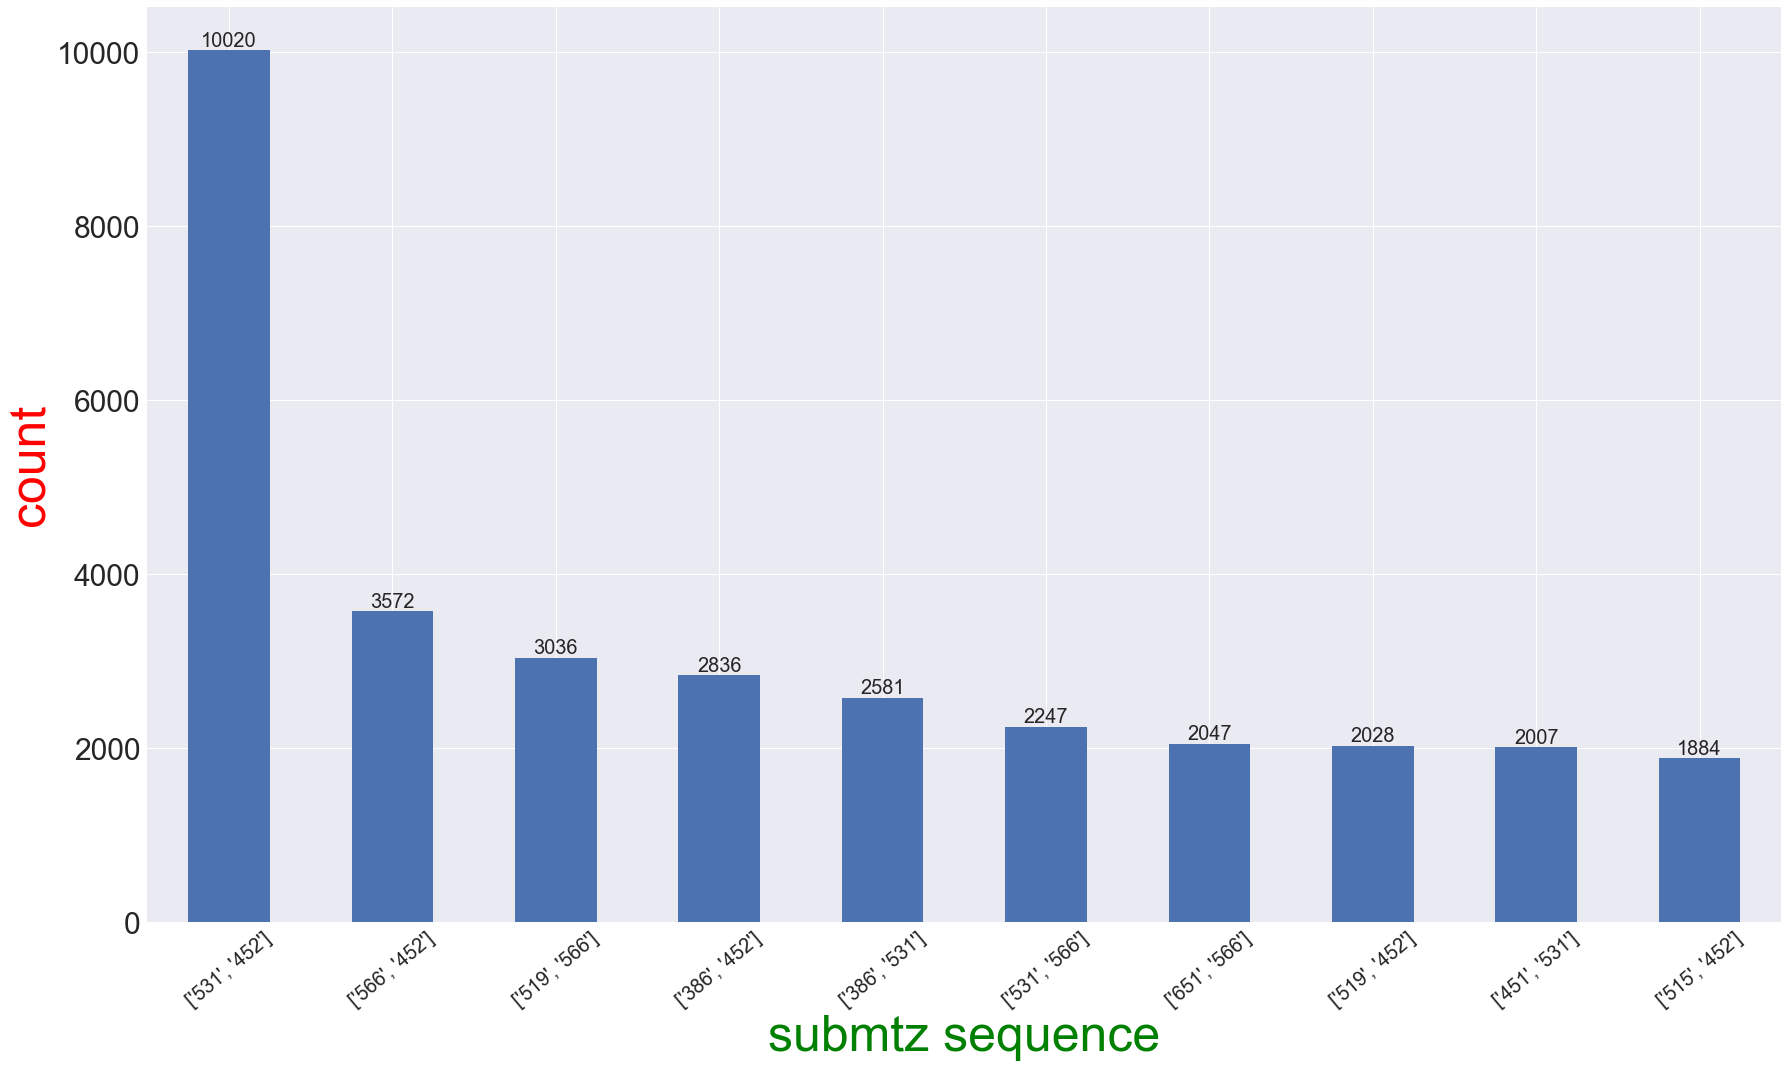

In [27]:
plot_frequent_submtz_by_country(indo_2, 2,10)

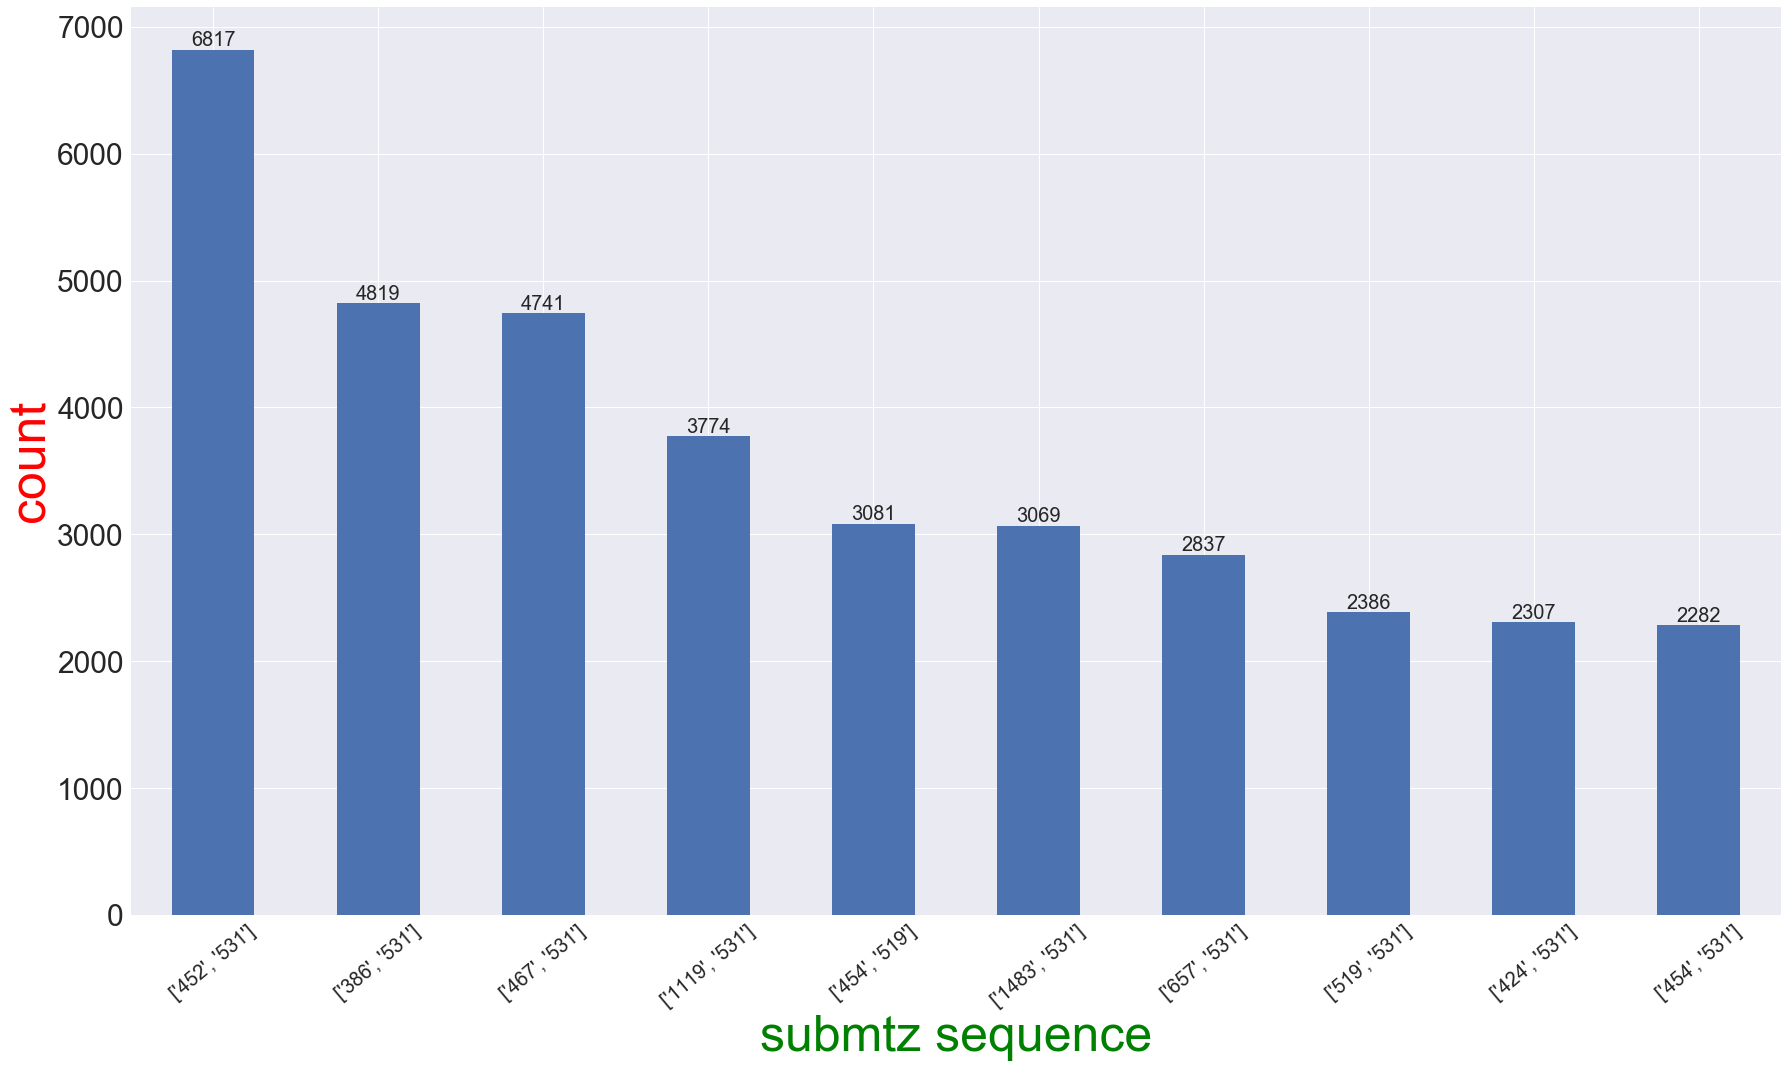

In [18]:
plot_frequent_submtz_by_country(china_2, 2,10)

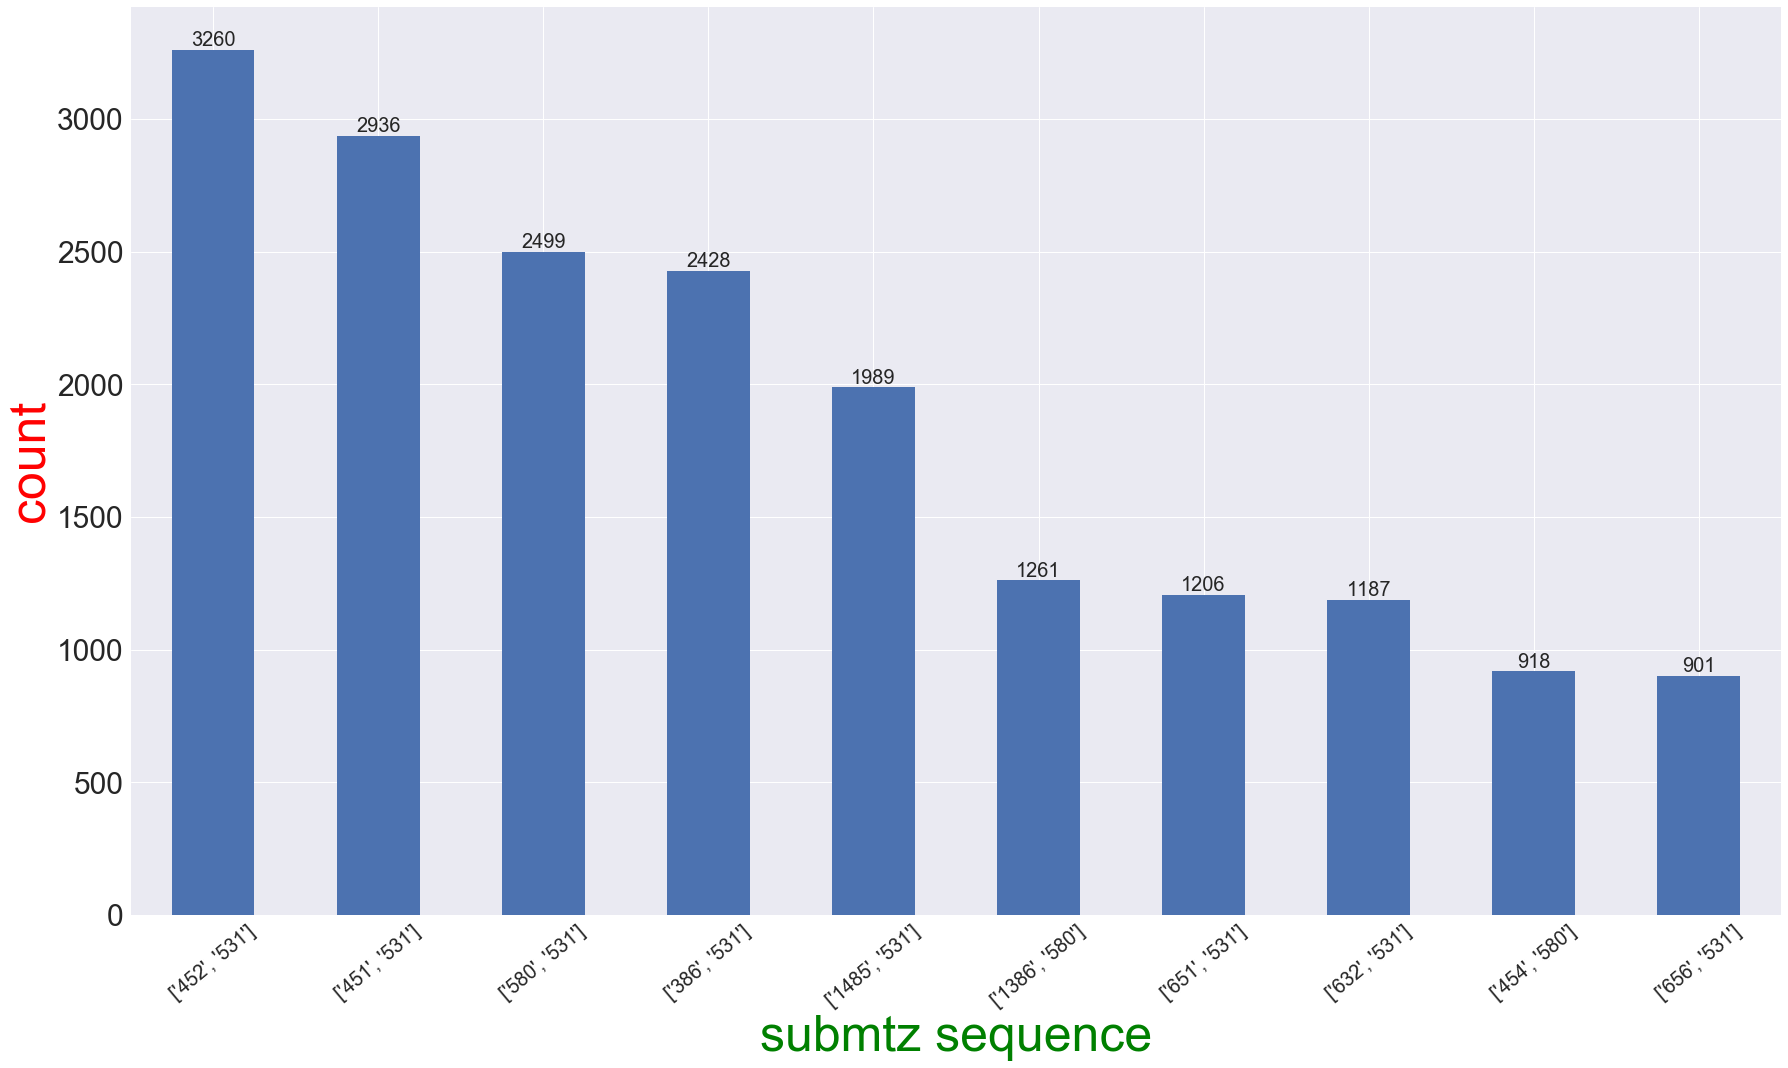

In [19]:
plot_frequent_submtz_by_country(india_2, 2,10)

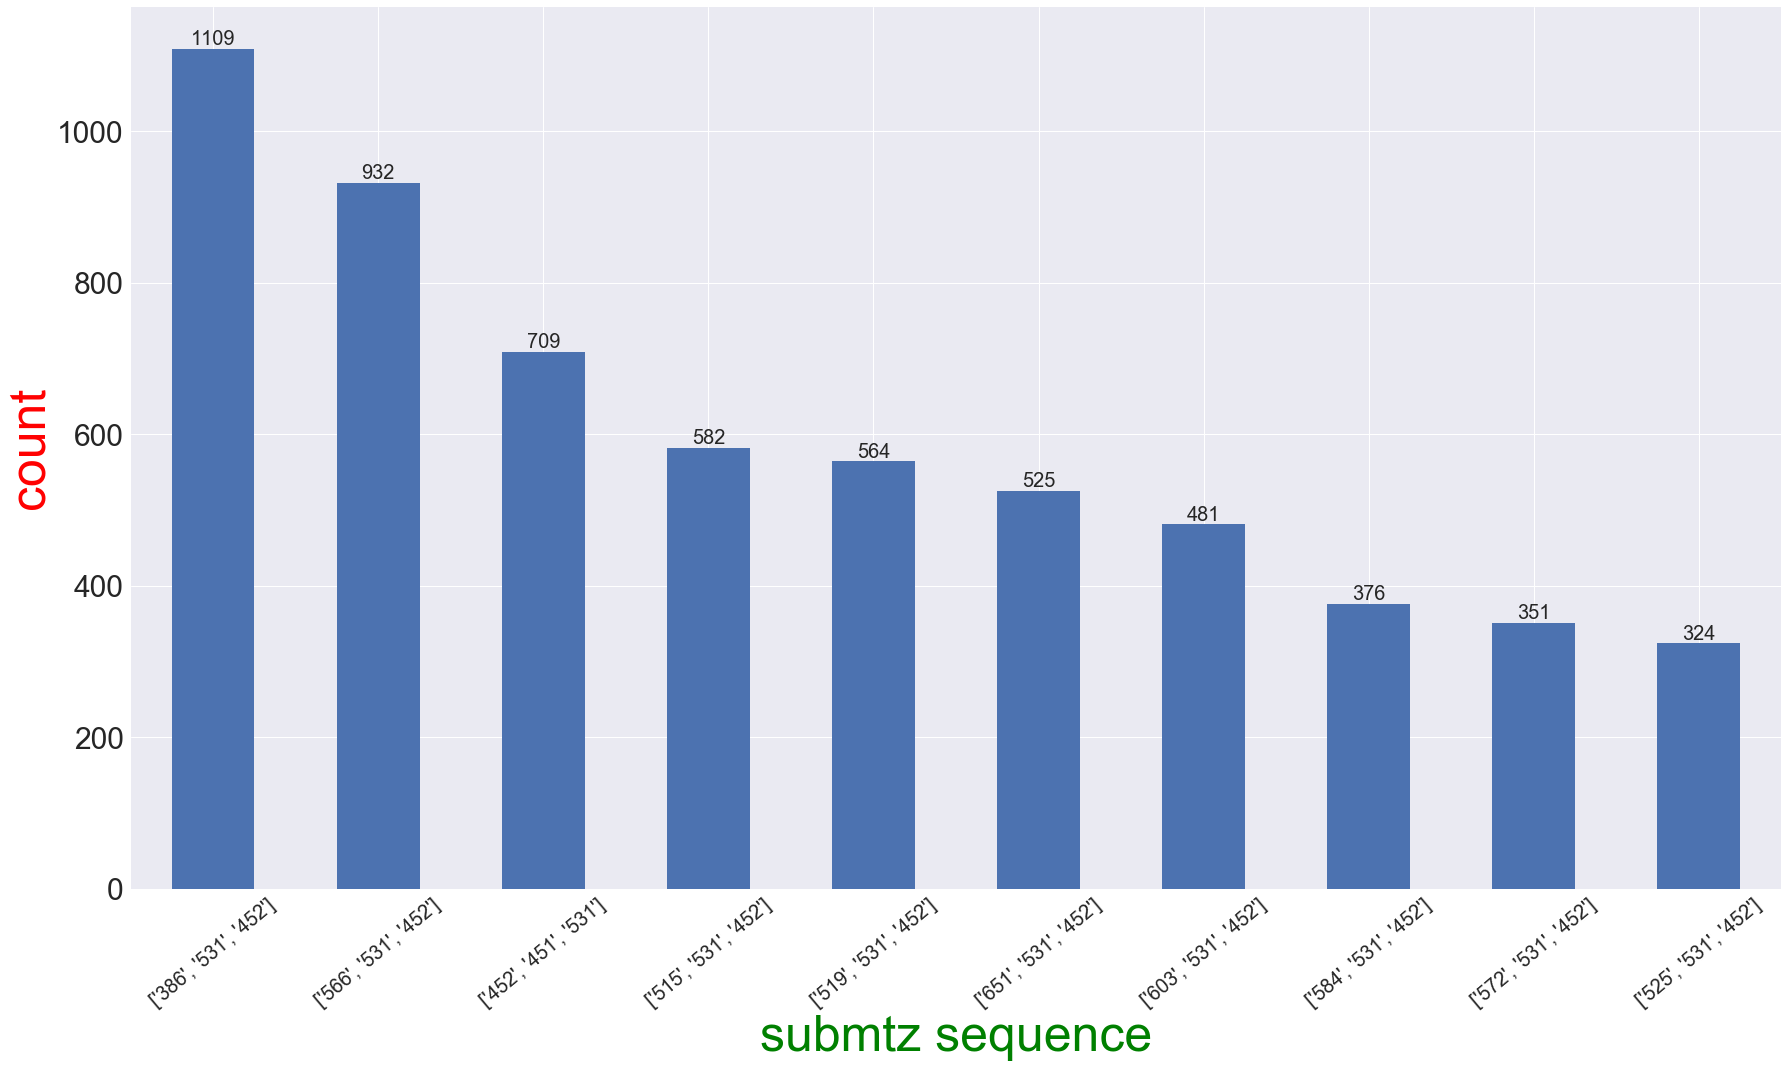

In [20]:
plot_frequent_submtz_by_country(indo_2, 3,10)

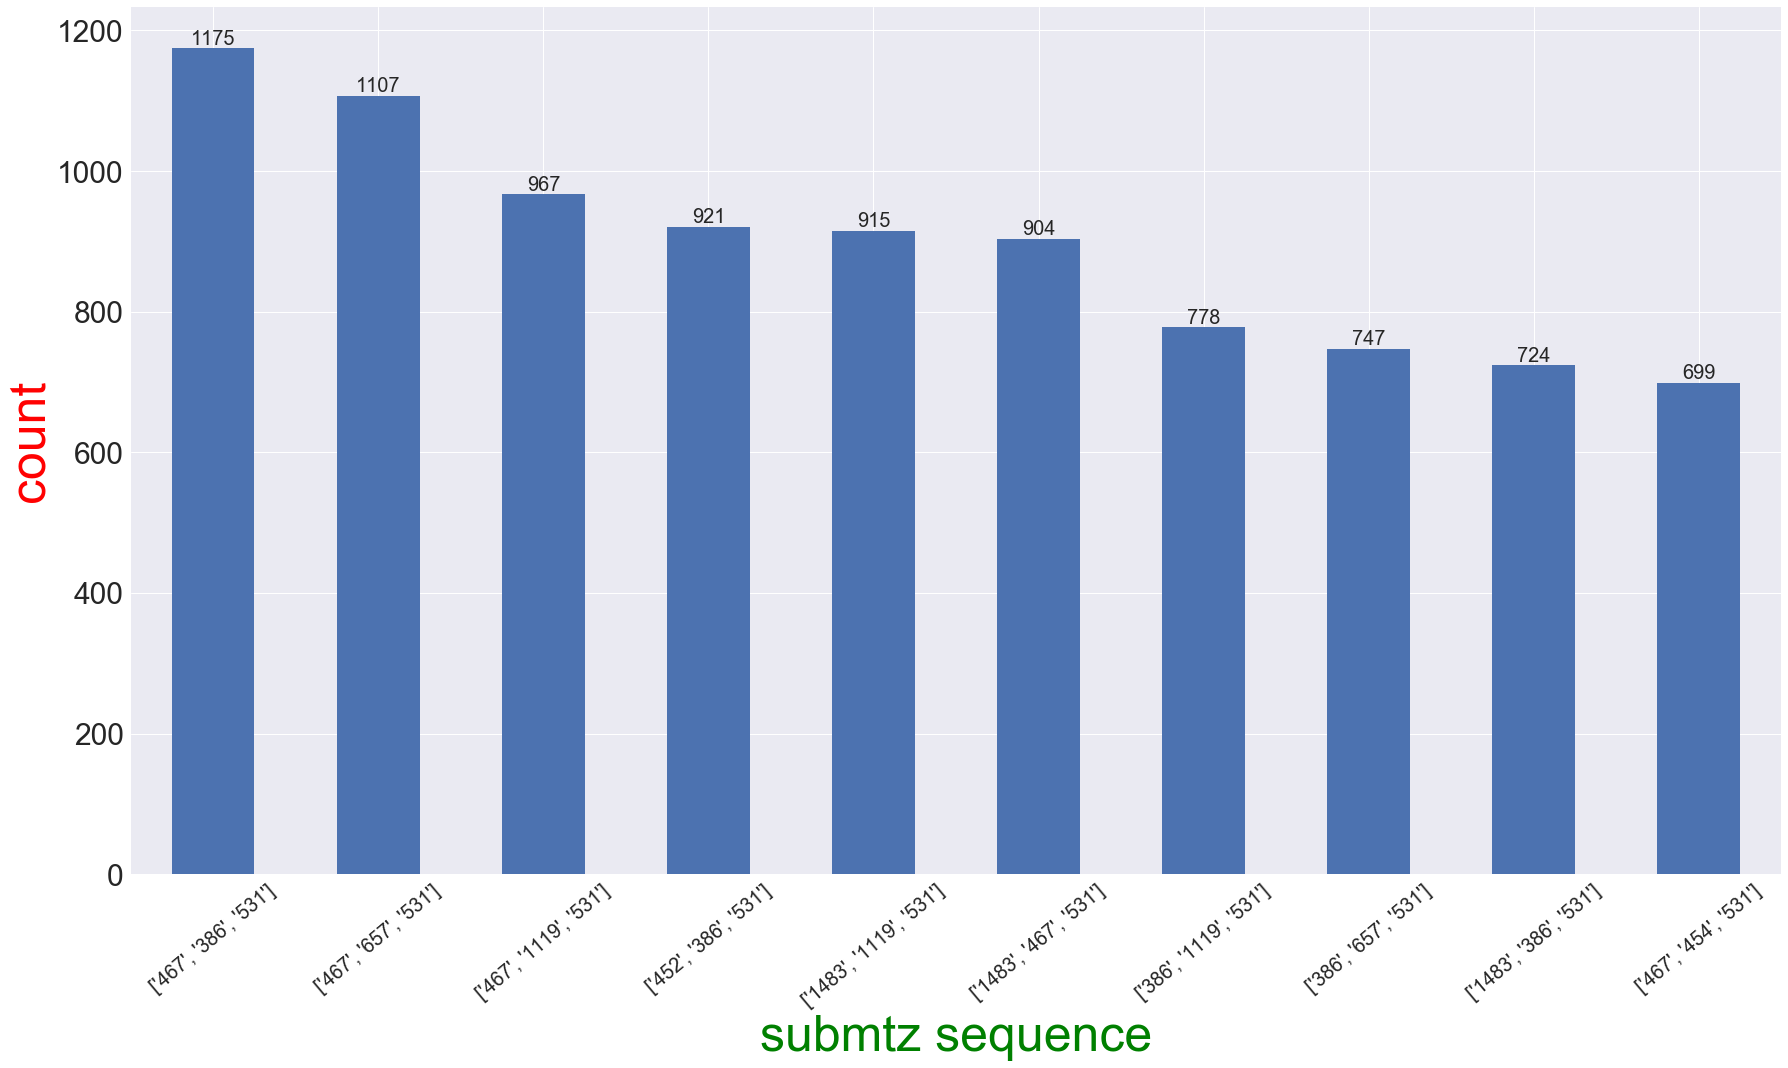

In [21]:
plot_frequent_submtz_by_country(china_2, 3,10)

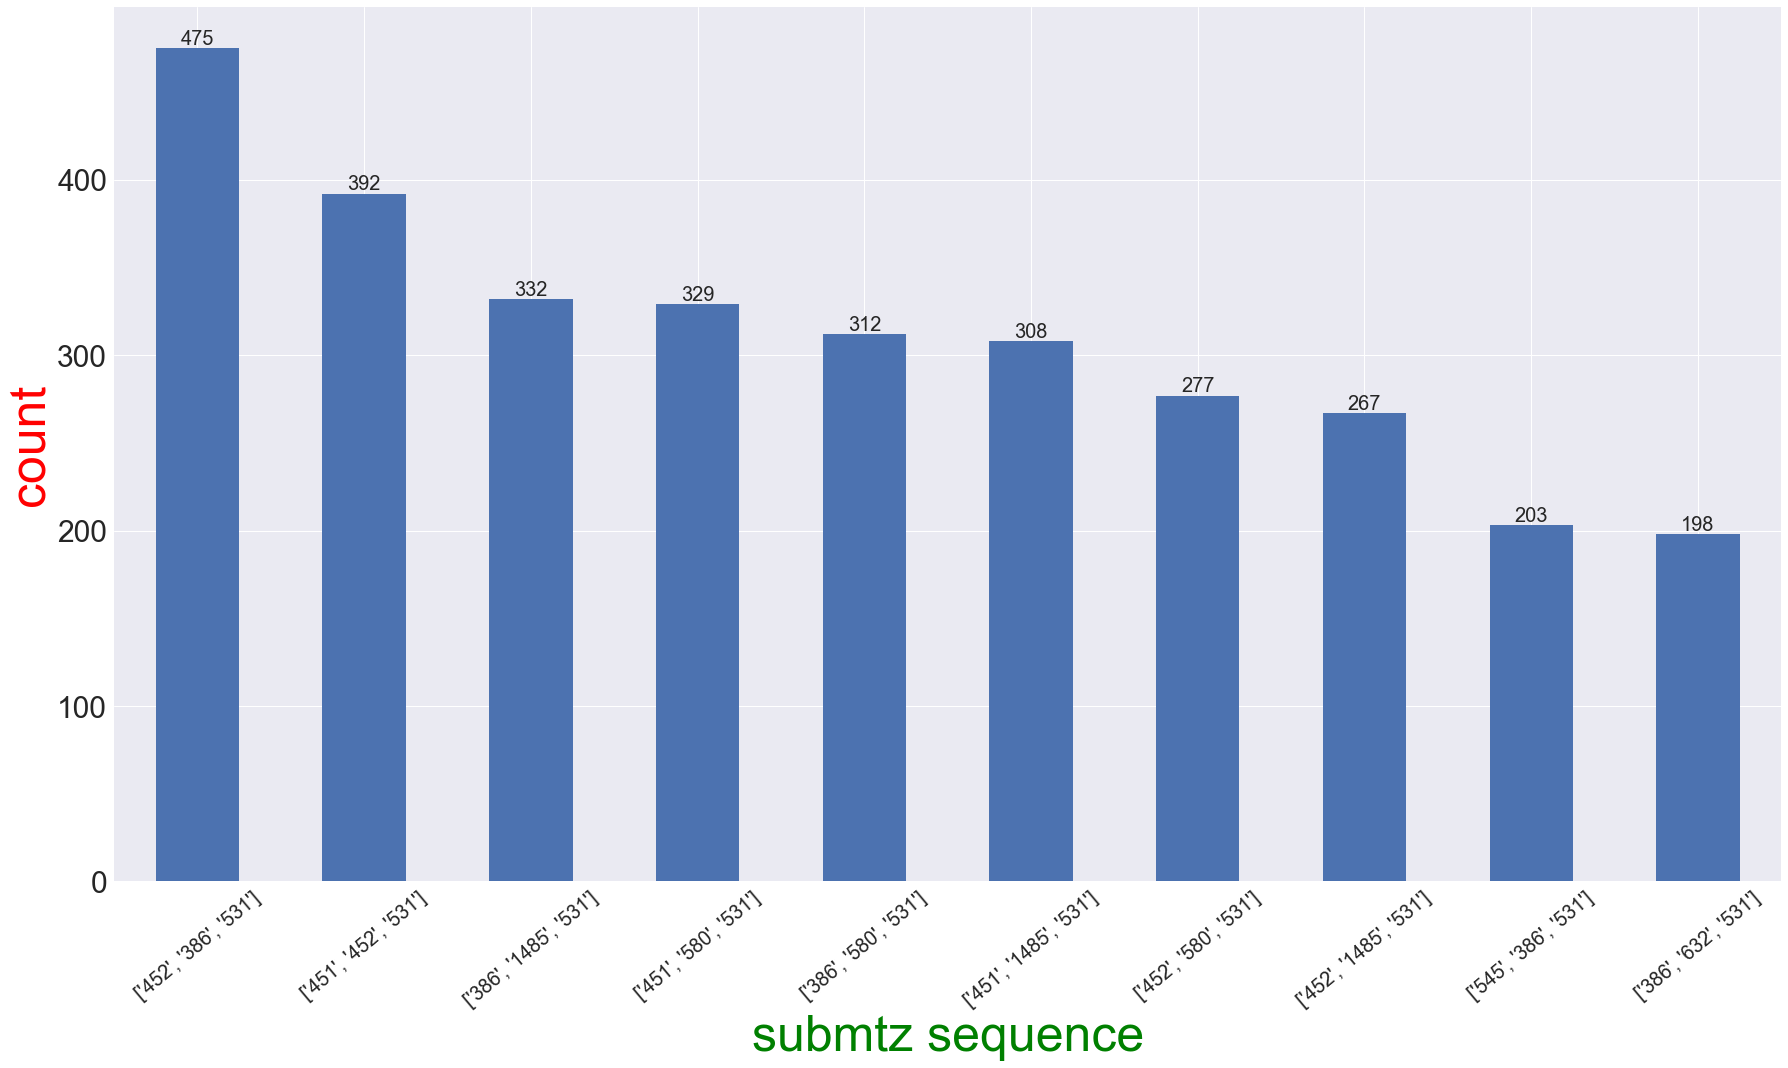

In [22]:
plot_frequent_submtz_by_country(india_2, 3,10)

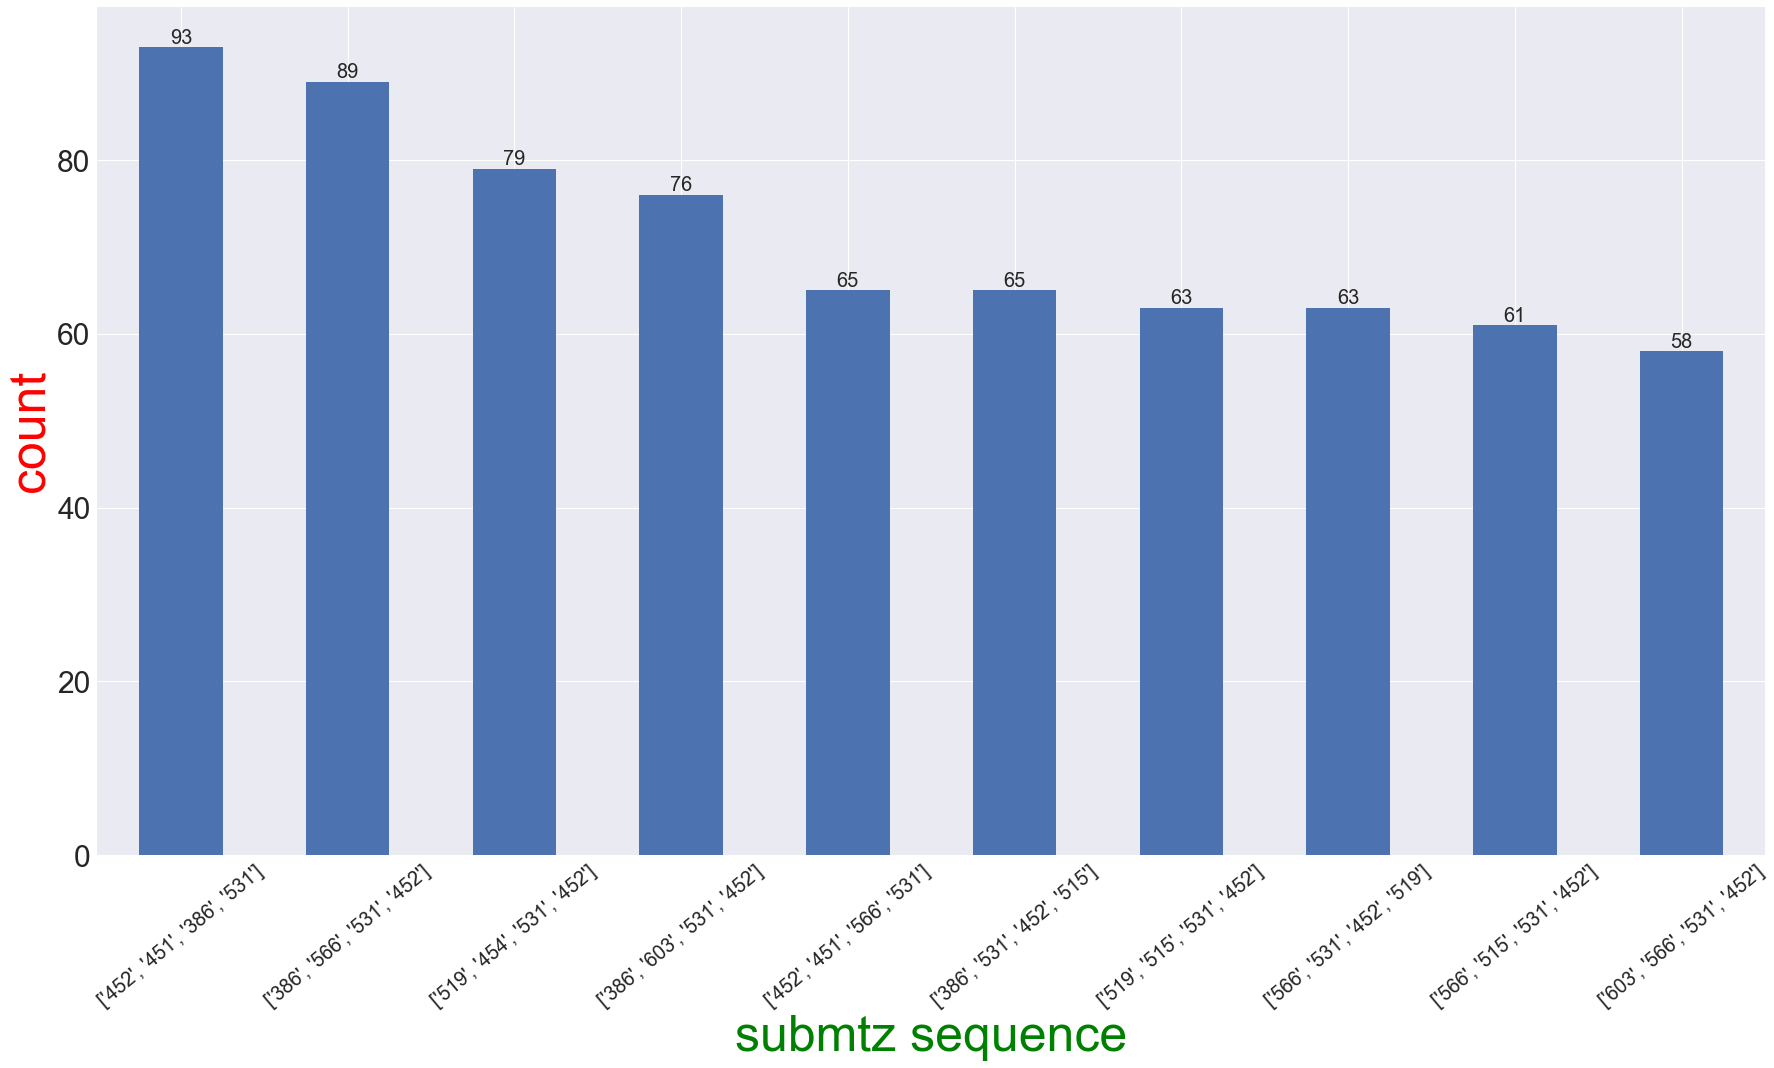

In [23]:
plot_frequent_submtz_by_country(indo_2, 4,10)

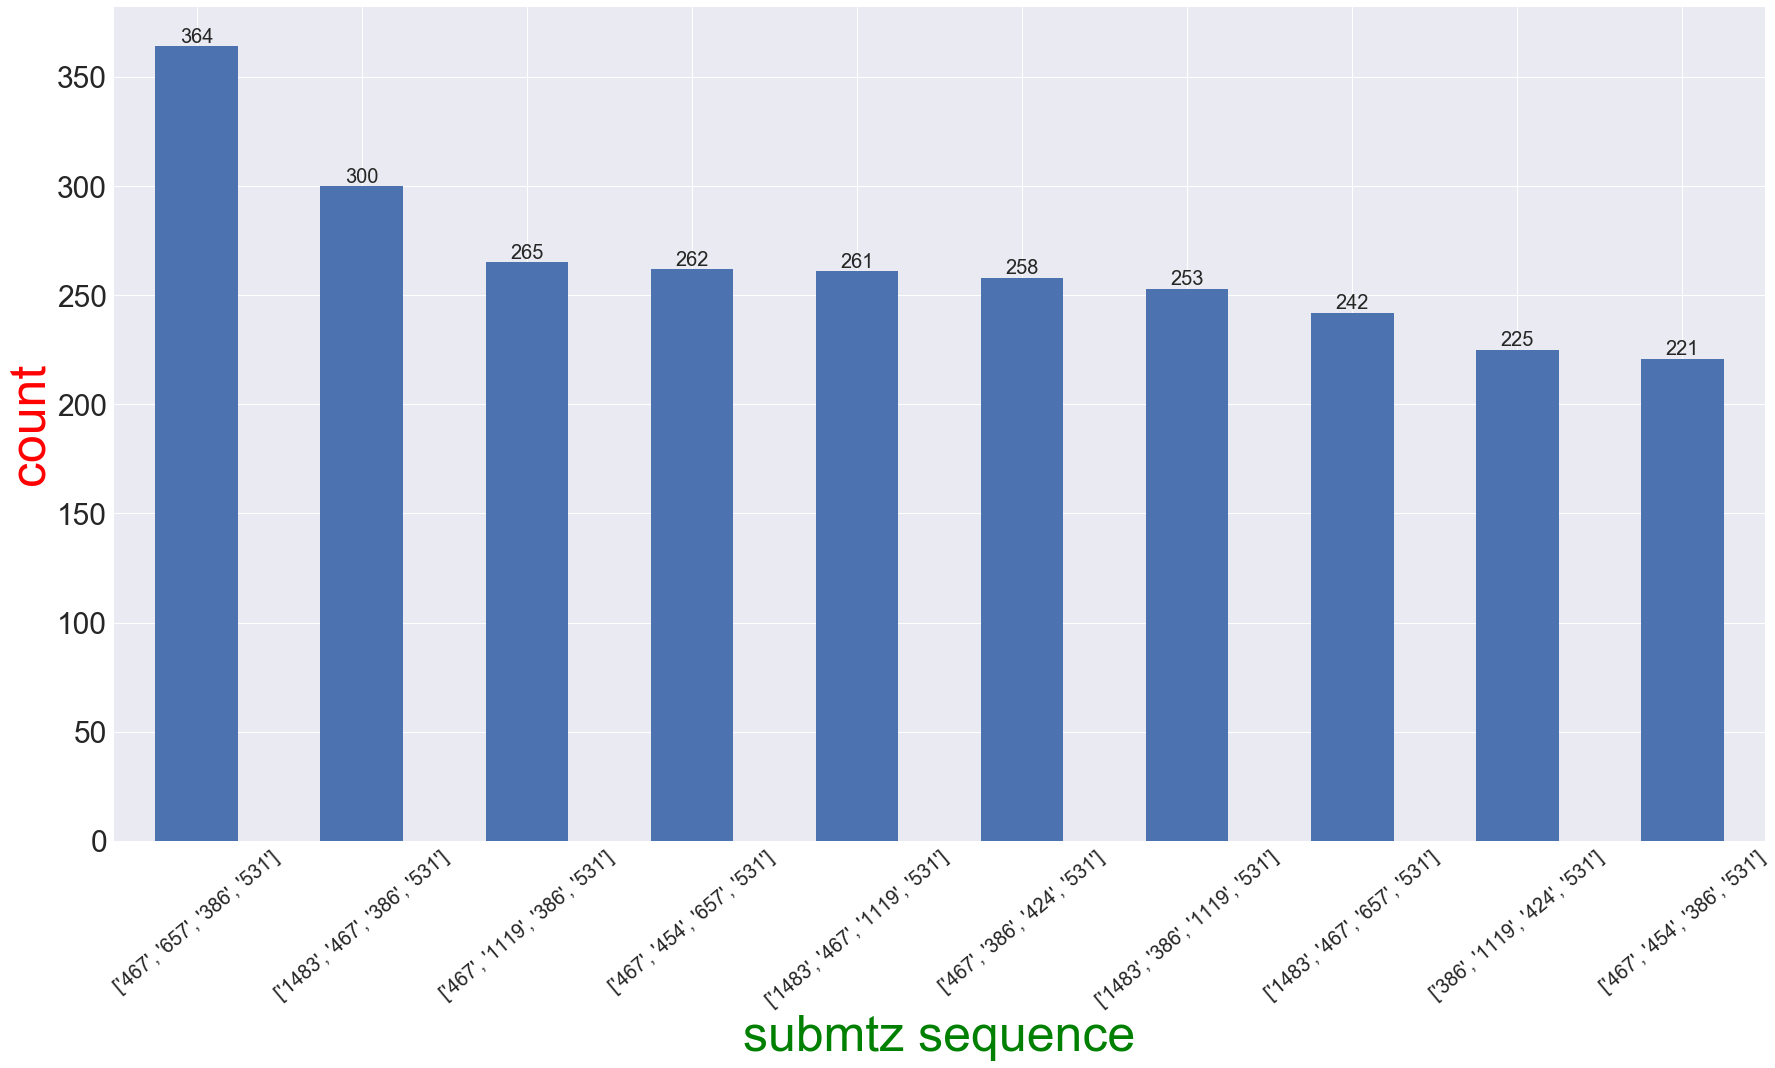

In [24]:
plot_frequent_submtz_by_country(china_2, 4,10)

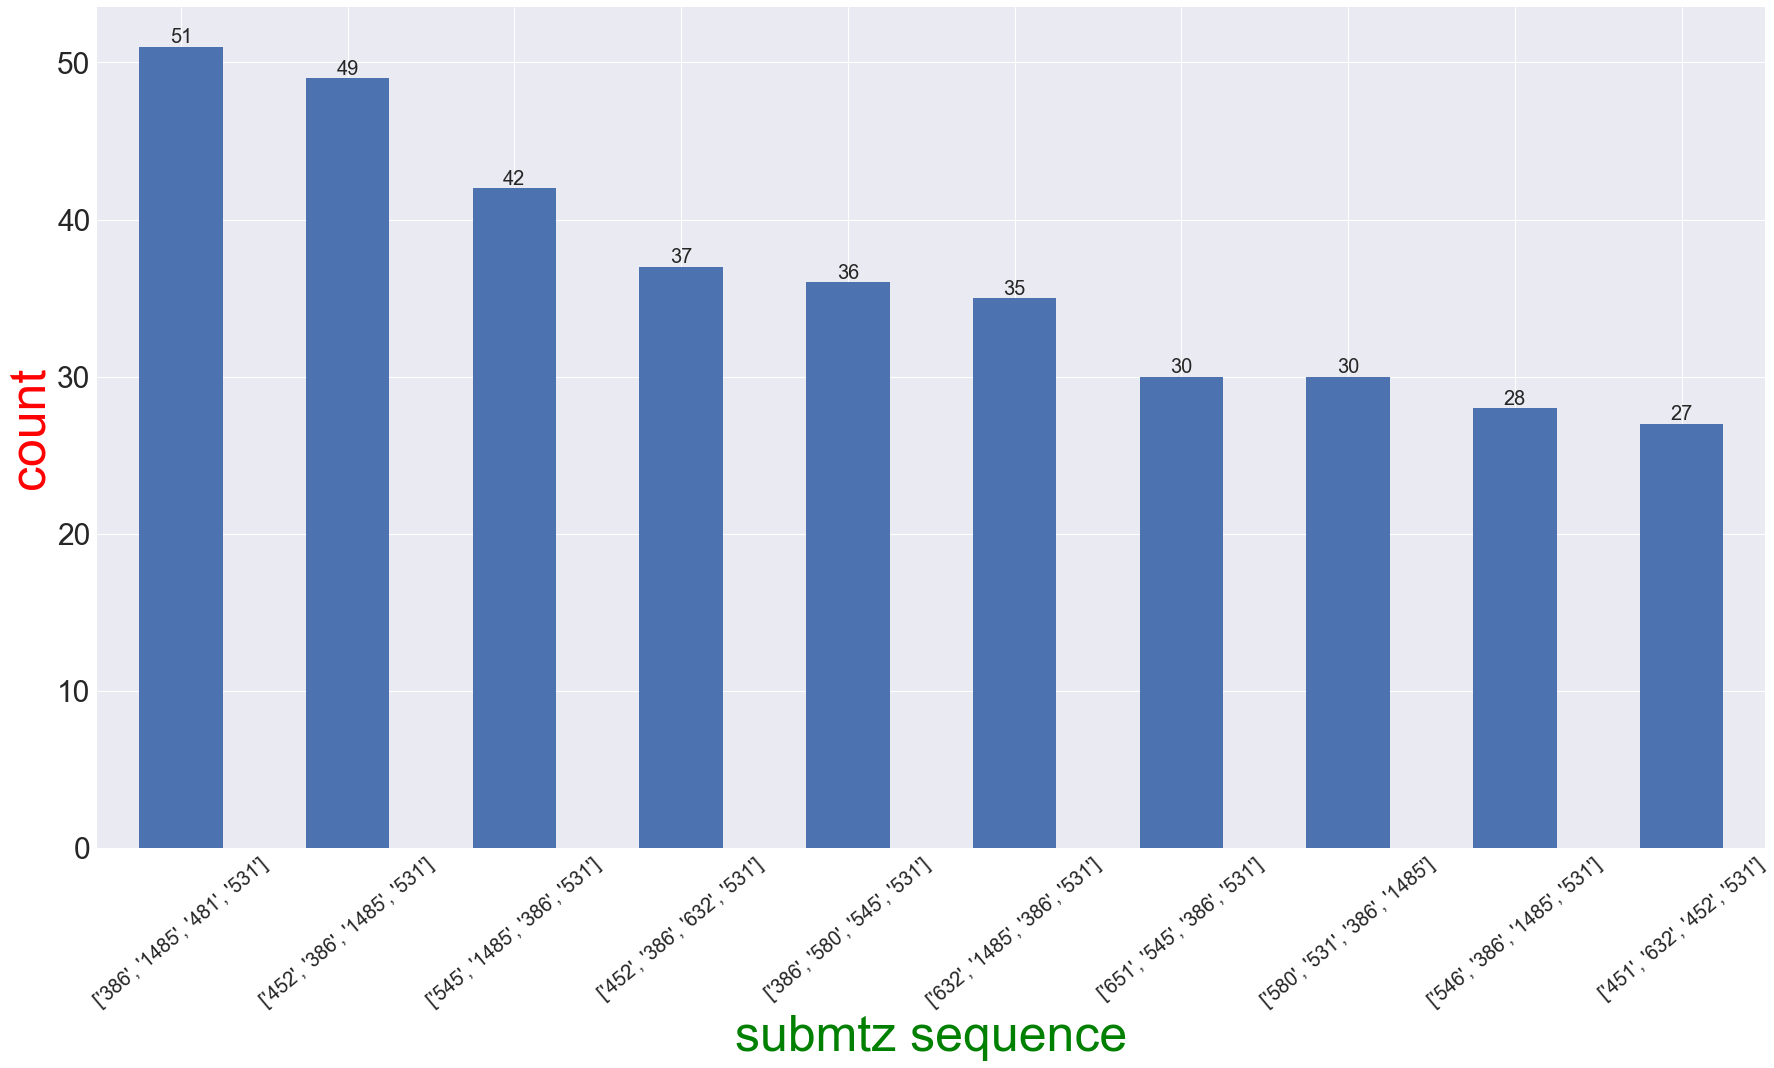

In [25]:
plot_frequent_submtz_by_country(india_2, 4,10)
